# !!Remember to add comma before the NOTES!! Organise the variable NAMES! MAGIC Numbers!

In [45]:
# import

## final transaction

In [46]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
from pyspark.sql.functions import *

In [47]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [48]:
# read the given transaction datasets
ori_transaction1 = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot').sort('order_datetime')
ori_transaction2 = spark.read.parquet('../data/tables/transactions_20210828_20220227_snapshot').sort('order_datetime')
ori_transaction3 = spark.read.parquet('../data/tables/transactions_20220228_20220828_snapshot').sort('order_datetime')

# read the given consumer datasets
tbl_consumer = spark.read.option("delimiter", "|").option("header",True).csv("../data/tables/tbl_consumer.csv")
consumer_detail = spark.read.parquet('../data/tables/consumer_user_details.parquet')

# read the fraud dataset
consumer_fraud = spark.read.option("header",True).csv('../data/tables/consumer_fraud_probability.csv')

# merge all the transaction data
ori_transaction = ori_transaction1.union(ori_transaction2)
ori_transaction = ori_transaction.union(ori_transaction3)
ori_transaction = ori_transaction.drop('order_id')

# delete outliers
wind = Window.partitionBy('merchant_abn')
q1= F.expr('percentile_approx(dollar_value, 0.25)')
q3= F.expr('percentile_approx(dollar_value, 0.75)')
testq = ori_transaction.withColumn('q1', q1.over(wind))
testq = testq.withColumn('q3', q3.over(wind))
testq = testq.withColumn('IQR', testq['q3']-testq['q1'])
dele_out = testq.where((testq["dollar_value"] <= testq["q1"]+1.5*testq["IQR"]) & (testq["dollar_value"] >= testq["q1"]-1.5*testq["IQR"]))
ori_transaction = dele_out.drop('q1','q3','IQR','order_id')

# give a definition, if a single transaction is over $10000, this is a big order
big_order_value = 10000
ori_transaction = ori_transaction.withColumn(
    "whether_bigorder",
    F.when(F.col('dollar_value')>=big_order_value, 1).otherwise(0))

# consumer datasets
consumer = consumer_detail.join(tbl_consumer, consumer_detail.consumer_id == tbl_consumer.consumer_id).drop(tbl_consumer.consumer_id)
consumer = consumer.select('user_id', 'postcode')

# change to the date format
consumer_fraud = consumer_fraud.select(col("user_id"),col("fraud_probability"),to_date(col("order_datetime"),"yyyy-MM-dd").alias("date"))

#filter the range for the fraud data
consumer_fraud = consumer_fraud.where(
        #clean the data outside the date range
        (F.col('date') >= '2021-02-28')& 
        (F.col('date') <= '2022-08-28'))

consumer_fraud_grouped = consumer_fraud.groupBy('user_id').agg(F.avg('fraud_probability').alias('average_prob_con'))
consumer_fraud_final = consumer_fraud_grouped.withColumn(
    "whether_fraud",
    F.when(F.col('average_prob_con')>=70, 1).otherwise(0))

consumer_final = consumer.join(consumer_fraud_final, consumer.user_id == consumer_fraud_final.user_id,'outer').drop(consumer_fraud_final.user_id).fillna(0).fillna(0)
#consumer_final.write.parquet(f"../data/curated/final_consumer.parquet")

transaction = ori_transaction.join(consumer_final, ori_transaction.user_id == consumer_final.user_id).drop(consumer_final.user_id)
transaction = transaction.sort(transaction.user_id)
#transaction.write.parquet(f"../data/curated/final_transaction.parquet")

## final merchant

In [49]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import *
import pandas as pd

In [50]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [51]:
# read the given merchant datasets
merchant_fraud = spark.read.option("header",True).csv('../data/tables/merchant_fraud_probability.csv')
tbl_merchants = spark.read.parquet('../data/tables/tbl_merchants.parquet')

# check the range of date

merchant_fraud = merchant_fraud.select(col("merchant_abn"),col("fraud_probability"),to_date(col("order_datetime"),"yyyy-MM-dd").alias("date"))

#filter the range for the fraud data
merchant_fraud = merchant_fraud.where(
        #clean the data outside the date range
        (F.col('date') >= '2021-02-28')& 
        (F.col('date') <= '2022-08-28'))
merchant_fraud_grouped = merchant_fraud.groupBy('merchant_abn').agg(F.count('fraud_probability').alias('fraud_count_abn'))

# preprocess the given merchant datasets
tbl_merchants_pd = tbl_merchants.toPandas()
for i in range(int(tbl_merchants_pd['tags'].count())):
    tbl_merchants_pd['tags'].iloc[i] = tbl_merchants_pd['tags'].iloc[i].replace(r'[', r'(').replace(r']', r')')
tbl_merchants_pd['tags'] = tbl_merchants_pd['tags'].str.lower()

# split the column into three columns and give names to the columns
merchant_tags = tbl_merchants_pd['tags'].str.split(')', expand=True)
for row in range(int(len(merchant_tags))):
    for col in range(3):
        merchant_tags.iloc[row,col] = merchant_tags.iloc[row,col].replace(r'((', r'').replace(r', (', r'').replace(r'take rate:', r'')
merchant_tags.rename(columns = {0 : 'Store_type', 1 : 'Revenue_levels', 2 : 'Take_rate'}, inplace = True)
merchant_tags = merchant_tags[['Store_type', 'Revenue_levels', 'Take_rate']]

tbl_merchants_pd[['Store_type', 'Revenue_levels', 'Take_rate']] = merchant_tags[['Store_type', 'Revenue_levels', 'Take_rate']]


for i in range(len(tbl_merchants_pd)):
    tbl_merchants_pd['Store_type'][i] = ' '.join(tbl_merchants_pd['Store_type'][i].split())

# export the merchant dataset
merchants = tbl_merchants_pd[['merchant_abn', 'Store_type', 'Revenue_levels', 'Take_rate']]
merchants.to_parquet(f"../data/curated/final_merchant.parquet")

/var/folders/63/097df8mn6r1d0btnhwhjpkr40000gn/T/ipykernel_12669/3037550658.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_merchants_pd['tags'].iloc[i] = tbl_merchants_pd['tags'].iloc[i].replace(r'[', r'(').replace(r']', r')')
/var/folders/63/097df8mn6r1d0btnhwhjpkr40000gn/T/ipykernel_12669/3037550658.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_merchants_pd['Store_type'][i] = ' '.join(tbl_merchants_pd['Store_type'][i].split())


## read external data

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [52]:
import os
import numpy as np
import pandas as pd
import zipfile
import pandas as pd
import geopandas as gpd
from dbfread import DBF
from urllib.request import urlretrieve
from urllib.error import HTTPError
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

In [53]:
#Go back one level from notebook to data 
output_relative_dir = '../data/'

if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)
    
for target_dir in ('curated','outer'):
    if not os.path.exists(output_relative_dir + target_dir):
        os.makedirs(output_relative_dir + target_dir)

# Download census data
url = "https://www.abs.gov.au/census/find-census-data/datapacks/download/2021_GCP_SA2_for_AUS_short-header.zip"#year-month.parquet
output_dir = "../data/outer/census.zip"
# download
urlretrieve(url, output_dir) 

files = zipfile.ZipFile('../data/outer/census.zip','r')

for file in files.namelist():
    files.extract(file, f"../data/outer/census")

types = ["A", "B"]
for type in types:
    G04= spark.read.option("header",True).csv(f'../data/outer/census/2021 Census GCP Statistical Area 2 for AUS/2021Census_G04{type}_AUST_SA2.csv') #read the parquet 
    G04 = G04.na.drop(subset=G04.columns)
    G04.write.mode("overwrite").parquet(f"../data/curated/census_data_2021_04{type}.parquet")

types = ["A", "B", "C"]
for type in types:
    G17= spark.read.option("header",True).csv(f'../data/outer/census/2021 Census GCP Statistical Area 2 for AUS/2021Census_G17{type}_AUST_SA2.csv') #read the parquet 
    G17 = G17.na.drop(subset=G17.columns)

    G17.write.mode("overwrite").parquet(f"../data/curated/census_data_2021_17{type}.parquet")

# Download postcode and SA2 data
url = "http://github.com/matthewproctor/australianpostcodes/zipball/master"
output_dir = "../data/outer/total_pto2.zip"
# download
urlretrieve(url, output_dir) 

files = zipfile.ZipFile('../data/outer/total_pto2.zip','r')
for file in files.namelist():
    files.extract(file, f"../data/outer/total_pto2")

post_sa2= spark.read.option("header",True).csv('../data/outer/total_pto2/matthewproctor-australianpostcodes-6f8a994/australian_postcodes.csv') 
print(post_sa2.dtypes)
post_sa2 = post_sa2.select("id", "postcode", "Lat_precise", "Long_precise", "SA2_MAINCODE_2016")
print(post_sa2.count() - post_sa2.na.drop().count())
post_sa2 = post_sa2.na.drop()
#177 rows with nulls dropped

#get the average latitude and longitude of the postcode if it have duplicates
post_sa2 = post_sa2\
    .withColumn("Lat_double", post_sa2["Lat_precise"].cast("double"))\
    .withColumn("Long_double", post_sa2["Long_precise"].cast("double"))
post_sa2 = post_sa2\
    .groupBy("postcode", "SA2_MAINCODE_2016")\
    .agg(F.avg("Lat_double").alias("avg_lat"), F.avg("Long_double").alias("avg_long"))

post_sa2.write.mode("overwrite").parquet("../data/curated/postcode_SA2.parquet")

# Download SA2 2021 information
url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/SA2_2021_AUST_SHP_GDA2020.zip" 
#year-month.parquet
output_dir = "../data/outer/2021sa2_shapefile.zip"
# download
urlretrieve(url, output_dir) 
print("complete")

files = zipfile.ZipFile('../data/outer/2021sa2_shapefile.zip','r')
for file in files.namelist():
    files.extract(file, f"../data/outer/2021sa2_shapefile")

# Download shapefile for each SA2 region
# !!!WARNING!!! THIS CODE IS GOING TO TAKE 10 MINUTES
def get_shapefile(url):
    geojson_option = "?_profile=oai&_mediatype=application/geo+json"
    try:
        shape = str(gpd.read_file(url + geojson_option).iat[0,-1])
    except HTTPError:
        shape = ""
    return shape

get_shapefile_udf = udf(lambda a: get_shapefile(a),StringType())

path = r'../data/outer/2021sa2_shapefile/SA2_2021_AUST_GDA2020.dbf' 
table = DBF(path)
sa2_pd_temp = pd.DataFrame(iter(table))
sa2_2021_temp = spark.createDataFrame(sa2_pd_temp) 

sa2_2021_vic = sa2_2021_temp.filter(F.col("STE_NAME21")=="Victoria")
sa2_2021_vic_w_geo = sa2_2021_vic.withColumn("geometry", get_shapefile_udf(F.col("LOCI_URI21")))
sa2_2021_vic.count()


too big can't write to parquet

In [66]:
sa2_2021_vic_w_geo = sa2_2021_vic_w_geo.select("SA2_CODE21", "SA2_NAME21", "geometry")
sa2_2021_vic_w_geo.write.option("maxRecordsPerFile", 20).mode("overwrite").parquet("../data/curated/SA2_2021_VIC_shapefile.parquet")

#sa2_2021_vic_w_geo.write.option("maxRecordsPerFile", 20).mode("overwrite").parquet("../data/curated/SA2_2021_VIC_shapefile.parquet")
#sa2_2021_ = sa2_2021_temp.select("SA2_CODE21")
#sa2_2021_.count

objc[14023]: +[__NSPlaceholderDate initialize] may have been in progress in another thread when fork() was called.
objc[14023]: +[__NSPlaceholderDate initialize] may have been in progress in another thread when fork() was called. We cannot safely call it or ignore it in the fork() child process. Crashing instead. Set a breakpoint on objc_initializeAfterForkError to debug.
objc[14019]: +[__NSPlaceholderDate initialize] may have been in progress in another thread when fork() was called.
objc[14019]: +[__NSPlaceholderDate initialize] may have been in progress in another thread when fork() was called. We cannot safely call it or ignore it in the fork() child process. Crashing instead. Set a breakpoint on objc_initializeAfterForkError to debug.


22/10/03 16:32:18 ERROR Executor: Exception in task 2.0 in stage 170.0 (TID 3815)
org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:581)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:91)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$

Py4JJavaError: An error occurred while calling o1739.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.jobAbortedError(QueryExecutionErrors.scala:638)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:278)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:186)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:584)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:30)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:560)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:116)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:860)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:390)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:363)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:793)
	at java.base/jdk.internal.reflect.DirectMethodHandleAccessor.invoke(DirectMethodHandleAccessor.java:104)
	at java.base/java.lang.reflect.Method.invoke(Method.java:577)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 170.0 failed 1 times, most recent failure: Lost task 2.0 in stage 170.0 (TID 3815) (10.12.245.212 executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:581)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:91)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:313)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:256)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:76)
	... 19 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:245)
	... 40 more
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:599)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:581)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:91)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:68)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:313)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$write$21(FileFormatWriter.scala:256)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$2.read(PythonUDFRunner.scala:76)
	... 19 more


In [ ]:
sa2_2021_temp(5)

KeyboardInterrupt: 

In [67]:
# Download file with 2016 SA2 info and 2021 SA2 info
url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/correspondences/CG_SA2_2016_SA2_2021.csv"
output_dir = "../data/outer/correspondences.csv"
# download
urlretrieve(url, output_dir) 

correspondences= spark.read.option("header",True).csv('../data/outer/correspondences.csv') #read the parquet 
correspondences = correspondences.na.drop()
correspondences.write.parquet("../data/curated/correspondences.parquet")

# Find 2016 post code and 2021 sa2 correspondence
print(post_sa2.dtypes)
print(correspondences.dtypes)
post_sa2_2021 = correspondences.join(post_sa2,correspondences.SA2_MAINCODE_2016 == post_sa2.SA2_MAINCODE_2016,"left") 

# JOIN tables
post_sa2_2021 = post_sa2_2021.drop("SA2_NAME_2016", "SA2_MAINCODE_2016")
#### post_sa2_2021.write.mode("overwrite").parquet("../data/curated/postcode_sa2_conrrespondences.parquet")

complete


## census_age&income

In [75]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from operator import add
from functools import reduce

In [ ]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [78]:
# read the external census datasets
census_04A_age = spark.read.parquet('../data/curated/census_data_2021_04A.parquet')
census_04B_age = spark.read.parquet('../data/curated/census_data_2021_04B.parquet')
census_17A_income = spark.read.parquet('../data/curated/census_data_2021_17A.parquet')
census_17B_income = spark.read.parquet('../data/curated/census_data_2021_17B.parquet')
census_17C_income = spark.read.parquet('../data/curated/census_data_2021_17C.parquet')
correspondences = spark.read.parquet('../data/curated/correspondences.parquet')
postcode = spark.read.parquet('../data/curated/postcode_SA2.parquet/')

#Merge the age dataframe
Age_Data = census_04A_age.join(census_04B_age, census_04A_age.SA2_CODE_2021 == census_04B_age.SA2_CODE_2021).drop(census_04B_age.SA2_CODE_2021)

#Select the column in the age dataframe (18-65) and calculate the sum
Age_Data_select = Age_Data.select(Age_Data.columns[0::18])
Age_Data_total = Age_Data_select.withColumn('result',reduce(add, [F.col(x) for x in Age_Data_select.columns[5:14]]))
Age_Data_total = Age_Data_total.select("SA2_CODE_2021","result","Tot_P")

Age_Data_rate = Age_Data_total.withColumn("age_percentage", Age_Data_total.result /Age_Data_total.Tot_P)
Age_Data_rate = Age_Data_rate.select("SA2_CODE_2021","age_percentage")

income = census_17A_income.join(census_17B_income, census_17A_income.SA2_CODE_2021 == census_17B_income.SA2_CODE_2021).drop(census_17B_income.SA2_CODE_2021)
income_data = income.join(census_17C_income, income.SA2_CODE_2021 == census_17C_income.SA2_CODE_2021).drop(census_17C_income.SA2_CODE_2021)

income_data_del = income_data.select(income_data.columns[0::10])
income_data_select = income_data_del.withColumn('result',reduce(add, [F.col(x) for x in income_data_del.columns[44:50]]))
income_Data_total = income_data_select.select("SA2_CODE_2021","result","P_Tot_Tot")

income_Data_total = income_Data_total.withColumn("income_percentage", income_Data_total.result / income_Data_total.P_Tot_Tot)
income_Data_total = income_Data_total.select("SA2_CODE_2021","income_percentage")

census_data = income_Data_total.join(Age_Data_rate, income_Data_total.SA2_CODE_2021 == Age_Data_rate.SA2_CODE_2021).drop(Age_Data_rate.SA2_CODE_2021)
#### census_data.write.parquet('../data/curated/final_census.parquet')


## Combine table

In [83]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
from pyspark.sql.functions import round
from pyspark.sql import Window

In [ ]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [85]:
# read the tables
transaction = spark.read.parquet('../data/curated/final_transaction.parquet')
merchants = spark.read.parquet('../data/curated/final_merchant.parquet')
consumer = spark.read.parquet('../data/curated/final_consumer.parquet')
census = spark.read.parquet('../data/curated/final_census.parquet')
post_sa2_2021 = spark.read.parquet("../data/curated/postcode_sa2_conrrespondences.parquet")

# group the tables, get the number of big order per merchant
grouped_transaction = transaction.groupBy('merchant_abn').agg(
    F.sum('dollar_value').alias('Amount'), F.count('dollar_value').alias('Count'), 
    F.sum('whether_bigorder').alias('count_of_bigorder')).sort('merchant_abn')
grouped_transaction.drop(F.col('order_id'))

# get the monthly average features
number_of_months = 18
grouped_transaction = grouped_transaction.withColumn('Avg_amount_monthly', round(grouped_transaction['Amount']/number_of_months, 2))
grouped_transaction = grouped_transaction.withColumn('Avg_count_monthly', round(grouped_transaction['Count']/number_of_months, 2))
grouped_transaction = grouped_transaction.withColumn('Order_avg_value', round(grouped_transaction.Amount/grouped_transaction.Count,2))
grouped_transaction = grouped_transaction.drop('Amount','Count')


merchant_data1 = merchants.join(grouped_transaction, merchants.merchant_abn == grouped_transaction.merchant_abn).drop(grouped_transaction.merchant_abn)
merchant_data1 = merchant_data1.drop('Amount','Count')
ori_transaction_1 = transaction.groupby('merchant_abn','user_id').agg(
    F.count('user_id').alias('count'), 
    F.avg('average_prob_con').alias('avg_prob_fraud_cus'),
    F.avg('whether_fraud').alias('whether_fraud'))

o_t = ori_transaction_1.groupby('merchant_abn').agg(
    F.count('user_id').alias('cnt'), 
    F.avg('avg_prob_fraud_cus').alias('avg_prob_fraud_cus'),
    F.sum('whether_fraud').alias('num_of_fraud'))

cus_per_mon = o_t.withColumn('prob_num_of_fraud', o_t.num_of_fraud/o_t.cnt)
cus_per_mon = cus_per_mon.withColumn('count_cus_per_mon', round(o_t['cnt']/number_of_months, 2))
cus_per_mon = cus_per_mon.drop('cnt')
cus_per_mon = cus_per_mon.drop('num_of_fraud')
ori_transaction_2 = transaction.groupby('merchant_abn', 'user_id').count()

ori_con_drop = ori_transaction_2.withColumn(
    "fixed_cus_num",
    F.when(F.col("count") >= 5, 1).otherwise(0))

ori_con_fix = ori_con_drop.groupby('merchant_abn').agg(F.sum('fixed_cus_num').alias('fix_cus_num'))

user_info = cus_per_mon.join(ori_con_fix, cus_per_mon.merchant_abn == ori_con_fix.merchant_abn).drop(ori_con_fix.merchant_abn)
user_info = user_info.drop('total_cus_num')
merchant_abn_and_consumer_id = transaction['merchant_abn', 'user_id']
user_id_and_postcode = consumer[['postcode','user_id']]

merchant_and_consumer_postcode = merchant_abn_and_consumer_id.join(user_id_and_postcode,['user_id'])
merchant_and_consumer_postcode = merchant_and_consumer_postcode['merchant_abn', 'postcode']

#https://stackoverflow.com/questions/36654162/mode-of-grouped-data-in-pyspark
counts = merchant_and_consumer_postcode.groupBy(['merchant_abn', 'postcode']).count().alias('counts')
merchant_postcode = (counts
          .groupBy('merchant_abn')
          .agg(F.max(F.struct(F.col('count'),
                              F.col('postcode'))).alias('max'))
          .select(F.col('merchant_abn'), F.col('max.postcode'))
         )

merchant_info = merchant_data1.join(merchant_postcode, merchant_data1.merchant_abn == merchant_postcode.merchant_abn).drop(merchant_data1.merchant_abn)
post_census = post_sa2_2021.join(census, post_sa2_2021.SA2_CODE_2021 == census.SA2_CODE_2021).drop(census.SA2_CODE_2021)
post_census_1 = post_census.groupBy('postcode')\
.agg(F.avg(F.col('income_percentage')).alias("avg_income_percentage"),
F.avg(F.col('age_percentage')).alias('avg_age_percentage'))
post_census_2 = post_census_1.select(post_census_1.postcode.cast('int'),post_census_1.avg_income_percentage, post_census_1.avg_age_percentage)

semifinal = merchant_info.join(user_info, merchant_info.merchant_abn == user_info.merchant_abn).drop(merchant_info.merchant_abn)
final = semifinal.join(post_census_2, semifinal.postcode == post_census_2.postcode, 'left').drop(post_census_2.postcode)
final = final.na.fill(value=0,subset=["avg_income_percentage", "avg_age_percentage"])
final = final.withColumn('Take_rate', final.Take_rate*final.Avg_amount_monthly)
final.write.parquet('../data/curated/merchant_info.parquet')

## geovisualisation

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import pandas as pd
import geopandas as gpd
import folium
from shapely.wkt import loads
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/10/04 01:06:59 WARN Utils: Your hostname, Macintosh.local resolves to a loopback address: 127.0.0.1; using 192.168.1.118 instead (on interface en0)
22/10/04 01:06:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 01:07:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/04 01:07:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/04 01:07:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/04 01:07:00 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [ ]:
geospark = spark.read.parquet('../data/curated/SA2_2021_VIC_shapefile.parquet/')
census = spark.read.parquet('../data/curated/final_census.parquet')
vic_data = geospark.join(census, geospark.SA2_CODE21 == census.SA2_CODE_2021, "left").drop(census.SA2_CODE_2021)

def visualisation(col_name, vic_data,geospark, title):
    data = vic_data.groupBy("SA2_CODE21").agg(F.avg(col_name).alias(col_name))
    pdf = geospark.select("SA2_CODE21", "geometry").toPandas()
    pdf['geometry'] = gpd.GeoSeries.from_wkt(pdf['geometry'])
    gdf = gpd.GeoDataFrame(pdf, geometry='geometry')
    geoJSON = gdf[['SA2_CODE21', 'geometry']].drop_duplicates('SA2_CODE21').to_json()
    m = folium.Map(location=[-37.84, 144.95], tiles="Stamen Terrain", zoom_start=10)
    # refer to the folium documentations on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=data.toPandas(), # data source
        columns=['SA2_CODE21',col_name], # the columns required
        key_on='properties.SA2_CODE21', # this is from the geoJSON's properties
        fill_color='YlOrRd', # color scheme
        nan_fill_color='black',
        legend_name=col_name
    )

    map = c.add_to(m)

    map.save('../plots/foliumChoropleth_'+col_name+'.html')
    map

visualisation("income_percentage", vic_data, geospark,"average income percentage by SA2")
visualisation("age_percentage", vic_data, geospark,"age_percentage")


## Visualization

In [86]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
import seaborn as sns
import numpy as np

In [87]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

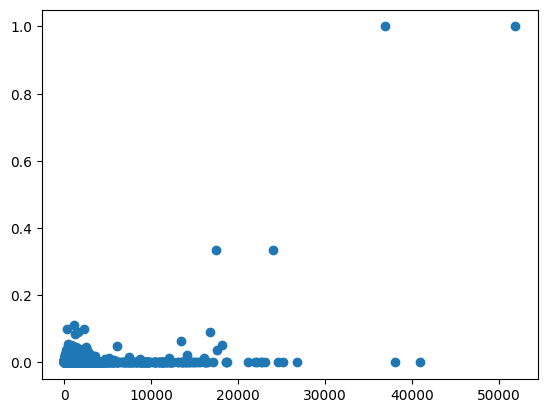

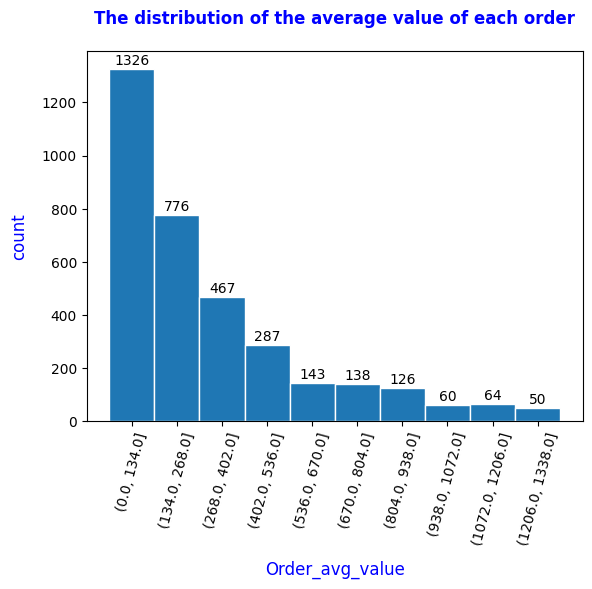

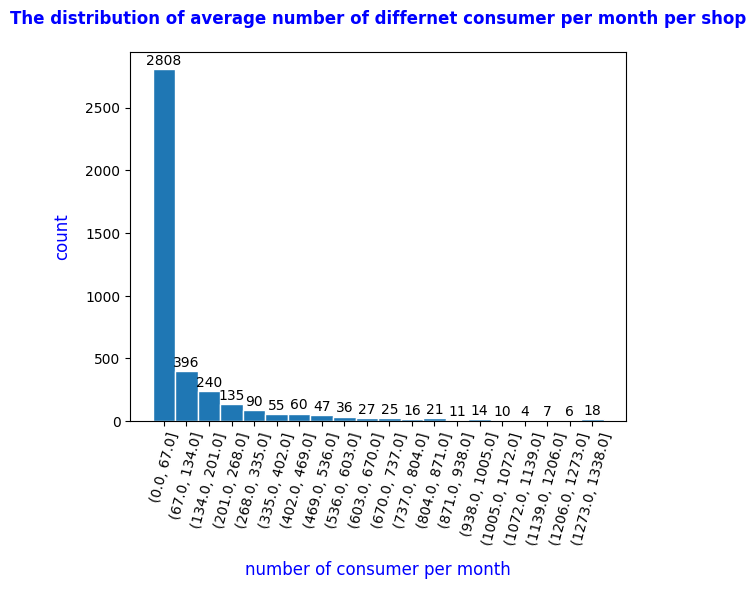

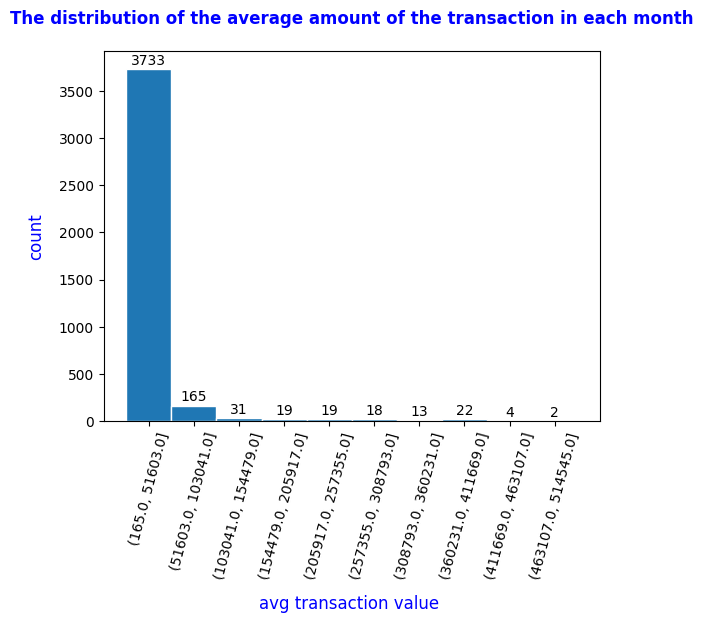

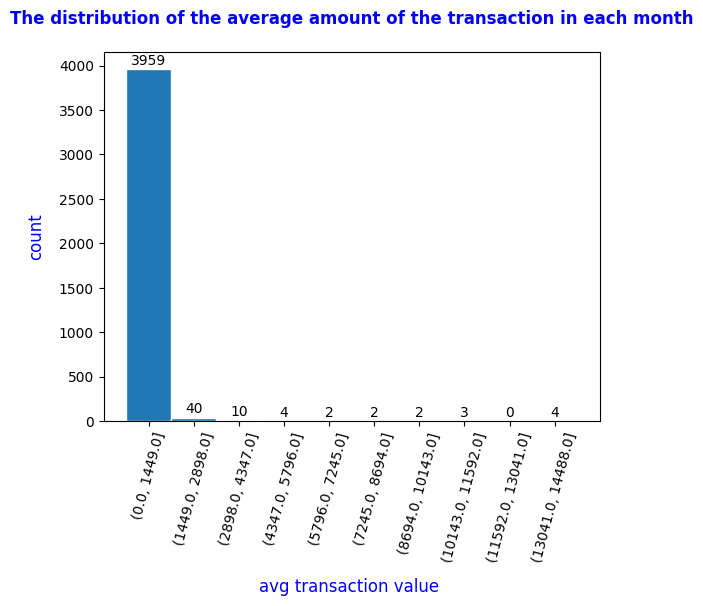

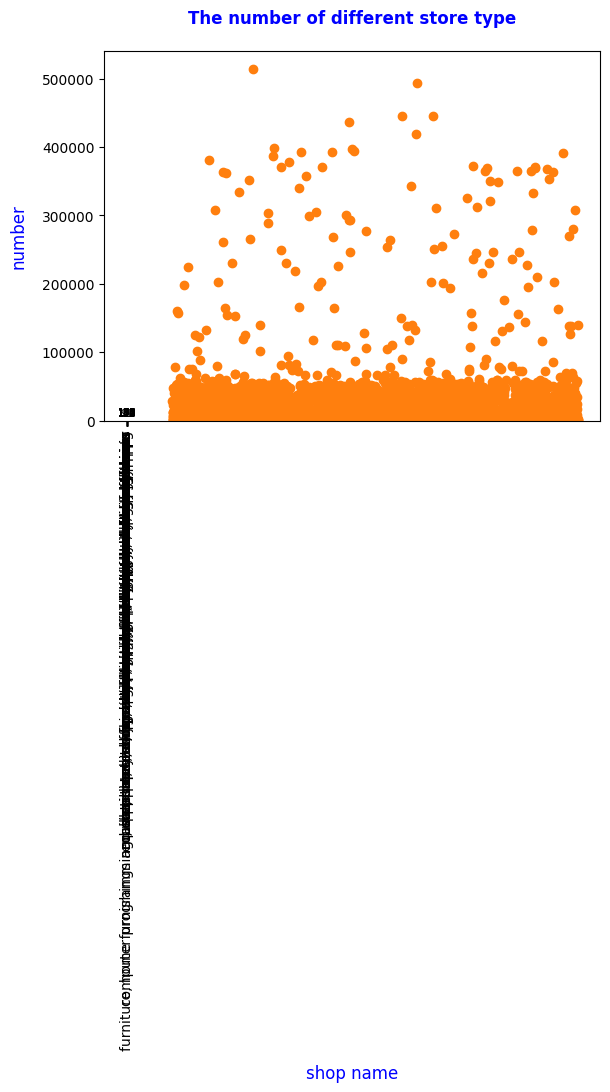

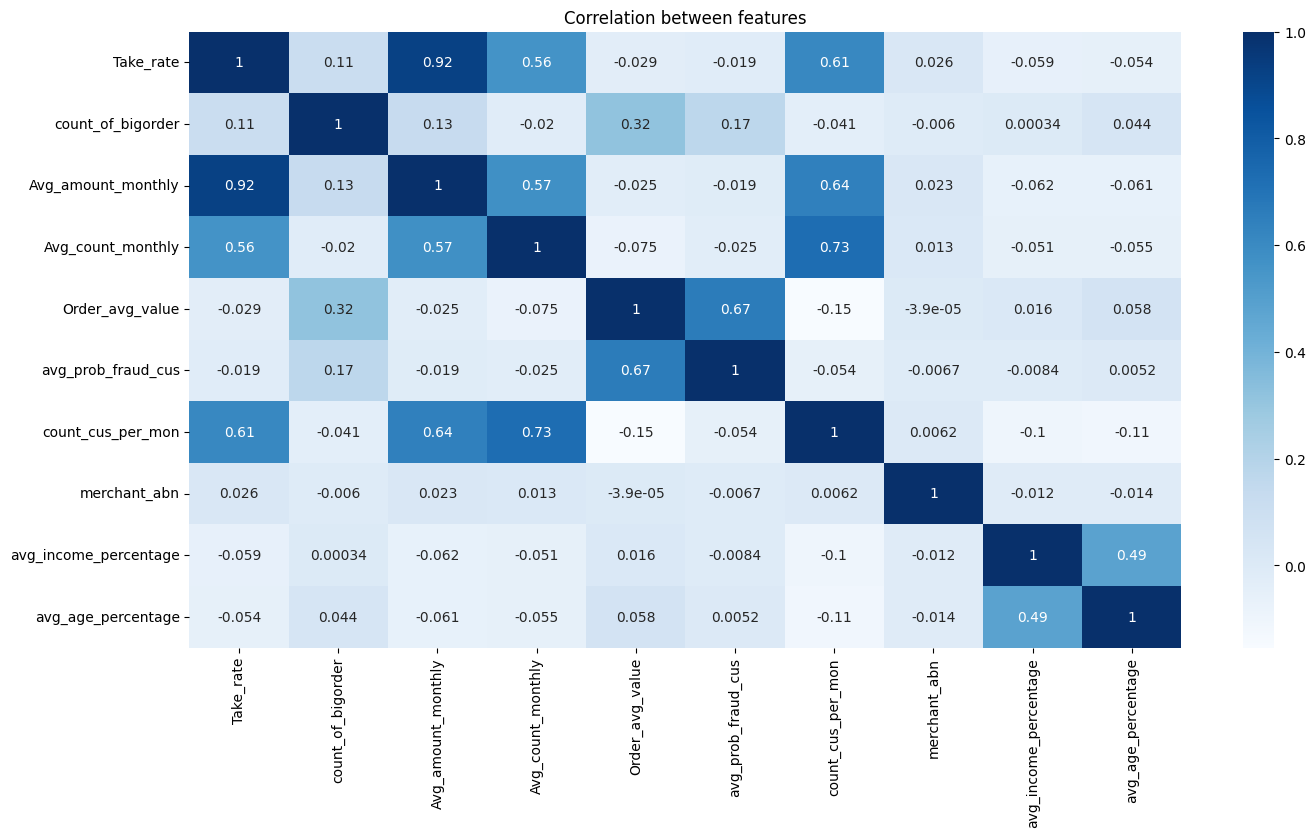

In [90]:
merchant_info = spark.read.parquet('../data/curated/merchant_info.parquet')
merchant_info.limit(3)
merchant_info = merchant_info.toPandas()
#View the relationship between travel_time_mins vs tip_amount
# plot

import matplotlib.pyplot as plt
plt.scatter(merchant_info['Order_avg_value'], merchant_info['prob_num_of_fraud'])
plt.show()
def get_bin(df,bar_num):
    bar_list = []
    max_value = int(df.max()+1)
    min_value = int(df.min())
    t_bar_range = max_value - min_value
    bar_range = np.round(t_bar_range/bar_num)
    for i in range(0 ,bar_num):
        num = min_value + i*bar_range
        bar_list.append(num)
    bar_list.append(max_value)
    return bar_list
# Order_avg_value
bins = get_bin(merchant_info['count_cus_per_mon'],10)

dff_count_cus_per_mon = merchant_info.groupby(pd.cut(merchant_info['Order_avg_value'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"Order_avg_value": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,11),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=75)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)

#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('Order_avg_value', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The distribution of the average value of each order', pad = 20, color = 'blue', weight = 'bold')
# count_cus_per_mon
bins = get_bin(merchant_info['count_cus_per_mon'],20)

dff_count_cus_per_mon = merchant_info.groupby(pd.cut(merchant_info['count_cus_per_mon'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"count_cus_per_mon": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,21),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=75)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)

#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('number of consumer per month', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The distribution of average number of differnet consumer per month per shop', pad = 20, color = 'blue', weight = 'bold')
# Avg_amount_monthly
bins = get_bin(merchant_info['Avg_amount_monthly'],10)

dff_count_cus_per_mon = merchant_info.groupby(pd.cut(merchant_info['Avg_amount_monthly'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"Avg_amount_monthly": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,11),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=75)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)

#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('avg transaction value ', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The distribution of the average amount of the transaction in each month', pad = 20, color = 'blue', weight = 'bold')
# Avg_count_monthly
bins = get_bin(merchant_info['Avg_count_monthly'],10)

dff_count_cus_per_mon = merchant_info.groupby(pd.cut(merchant_info['Avg_count_monthly'], bins=bins))['fix_cus_num'].count()
dff_count_cus_per_mon = dff_count_cus_per_mon.to_frame().reset_index()
dff = dff_count_cus_per_mon.rename(columns={"Avg_count_monthly": "index", "fix_cus_num": "count"})

fig, ax = plt.subplots()

y = dff['count']

bars = ax.bar(
    x = range(1,11),
    height = y, edgecolor='white',
    tick_label = dff['index'], width = 1
)
plt.xticks(rotation=75)

#add the average tip_amount number on the top of each bar chart
ax.bar_label(bars, padding=1, color = 'black', fontsize=10)
ax.xaxis.grid(False)

#show the bar chart and add the title and labels
ax.set_ylabel('count', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('avg transaction value ', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The distribution of the average amount of the transaction in each month', pad = 20, color = 'blue', weight = 'bold')
# store type
tz_df = merchant_info[['Store_type','Revenue_levels']].groupby(['Store_type']).count()

fig, ax = plt.subplots()

y = tz_df['Revenue_levels']

bars = ax.bar(
    x = range(1,26),
    height = y, edgecolor='white',
    tick_label = tz_df.index, width = 0.8
)

plt.xticks(rotation=90)
ax.bar_label(bars, padding=2, color = 'black', fontsize=7)
ax.xaxis.grid(False)

ax.set_ylabel('number', labelpad = 10, color = 'blue', fontsize=12)
ax.set_xlabel('shop name', labelpad = 10, color = 'blue', fontsize=12)
ax.set_title('The number of different store type', pad = 20, color = 'blue', weight = 'bold')

import matplotlib.pyplot as plt
plt.scatter(merchant_info['merchant_abn'], merchant_info['Avg_amount_monthly'])
plt.show()
Avg_amount_monthly_corr = merchant_info.drop(['prob_num_of_fraud','fix_cus_num'], axis =1)
import seaborn as sns
#draw the heatmap
plt.figure(figsize=(16,8))
cor = Avg_amount_monthly_corr.corr()
heatmap = sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
heatmap.set_title('Correlation between features')
plt.show()